In [39]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as np
import math

import matplotlib.pyplot as plt

### Data Generation

In [40]:
np.random.seed(32)

In [41]:
### Data of g function distribution
### Cos함수와 관련된 데이터를 만드는 함수

# cos(alpha_0*x_0 + alpha_1*x_1 + ... + alpha_n*x_n)
def Cos(samples, alpha, dim, xmax, xmin):
    """
    Generate datas we will use for the Model
    cos(alpha_0*x_0 + alpha_1*x_1 + ... + alpha_n*x_n)

    INPUT
    samples(int) : number of datas
    coefficients(array)\vec{\aplpha}] : coefficients for the x_i
    dim(int)[\vec{x}] : dimension of x data
    xmax : max value of each x_i
    xmin : min value of each x_i

    OUTPUT
    data sets(\vec{x}, cos(\vec{\alpha} \dot \vec{x}))
    """
    points= []
    results = []

    def f(alpha, point):
        if len(alpha) != len(point):
            ValueError("dimension of alpha and x is not same")
    
        a = np.dot(alpha, point)
        return a

    # Mading sample points
    for i in range(samples):
        
        point = []
        for j in range(dim):
            x = np.random.uniform(xmin[j], xmax[j])
            point.append(x)


        result = np.cos(f(alpha, point))

        points.append(point)
        results.append(result)

    return np.array(points, requires_grad = False), np.array(results, requires_grad = False)


# ------------------------------------------------------------------ #

#Xdata, ydata = Cos(10, [1, 2, 1/2], 3, xmax=[np.pi, np.pi, np.pi], xmin = [0, 0, 0])
#print(Xdata.shape)
#print(ydata)
#print(Xdata[:,0])

In [42]:
def plot_data(x, alpha, y, fig = None, ax = None):
    
    # Graph figure
    if fig == None :
        fig, ax = plt.subplots(1,1,figsize = (5, 5))
    
    def f(alpha, point):
        if len(alpha) != len(point):
            ValueError("dimension of alpha and x is not same")
    
        a = np.dot(alpha, point)
        return a

    for i in range(len(x)):
        x1 = f(alpha, x[i])
        x2 = y[i]
        s = np.linspace(0, 10)
        ax.scatter(x1, x2, alpha=0.5)
        ax.plot(s, np.cos(s))
        ax.set_xlabel("$x_{sum}$")
        ax.set_ylabel("$x_2$")

# ------------------------------------------------------------------ #

#fig, ax = plt.subplots(figsize=(4, 4))
#Xdata, ydata = Cos(1000, [1, 2, 1/2], 3, xmax=[np.pi, np.pi, np.pi], xmin = [0, 0, 0])
#plot_data(Xdata, [1, 2, 1/2], ydata, fig, ax)

### Variational Quantum Circuit Model

In [43]:
dev = qml.device("lightning.qubit", wires = 10)

@qml.qnode(dev)
def VQC_Model(thetas, phis, x, num_layers):
    """
    Variational Quantum Circuit model for Multi Variable Integration

    INPUT
    params : parameters for the circuit we will train them
    phis : array of parameters applied to the last RY gate
    x(Xdata[i]) : data point we have to upload
    num_layers : layers for the circuit

    OUTPUT
    Expectation value with PauliZ measure
    """
    
    dim = len(x)
    num_qubits = math.ceil(dim / 2)
    idx = 0

    params = list(thetas).copy()
    param_index = 1

    for _ in range(num_layers):
        for j in range(dim):
            params[param_index] = thetas[param_index] * x[j]
            param_index += 5
    
    for _ in range(num_layers):
        for i in range(dim):
            qubit = i // 2
            qml.RY(params[idx], wires = qubit)
            qml.RZ(params[idx+1]*x[i], wires = qubit, id = f'x{i}') # Re-uploading data here
            qml.RZ(params[idx+1], wires = qubit)
            qml.RY(params[idx+2], wires = qubit)
            qml.RZ(params[idx+3], wires = qubit)
            idx += 4

        if num_qubits > 1:
            for q in range(0,num_qubits-1,1):
                qml.CZ([q, q+1])
            if num_qubits > 2:
                qml.CZ([num_qubits-1, 0])

    if num_qubits > 1:
        for i in range(num_qubits):
           qml.RY(phis[i], wires=i, id = f"phi{i}")
    
    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
         obs = obs @ qml.PauliZ(i+1)

    return qml.expval(obs)

# ------------------------------------------------------------------ #

#Xdata, ydata = Cos(10, [1, 2, 1/2], 3, xmax=[np.pi, np.pi, np.pi], xmin = [0, 0, 0])
#x = Xdata[0]
#dim = len(x)
#num_layers = 2
#num_qubits = math.ceil(len(x) / 2)

#thetas = np.random.uniform(size = dim*num_layers*4,requires_grad = True)
#phis = np.random.uniform(size = num_qubits, requires_grad =True)


#print(thetas)
#print('------------------------------------------------------------------')
#print(VQC_Model(thetas, phis, x, num_layers))
#print('------------------------------------------------------------------')
#fig, ax = qml.draw_mpl(VQC_Model)(thetas, phis, x, num_layers)


In [44]:
#qml.gradients.param_shift(VQC_Model)(thetas, phis, x, num_layers)

### Cost function

원시함수를 구하기 위해 같은 양자회로를 사용할 수 있다.
> Example<br>
> $I(\alpha) = \int_{x_a}^{x_b} g(\alpha;x)d^n x$에 대해서 1차원 적분을 고려해보자.<br>
> 미적분의 기본 정리에 의하면,<br>
> $$I(\alpha) = G(\alpha; x_b) - G(\alpha; x_a)$$
> $G(\alpha;x) = \int g(\alpha; x)dx$이다.<br>

우리의 목표는 VQC의 미분을 학습기키는 것이다.<br>
모든 $x_j\in (x_a,x_b)$에 대해서 g의 값에 근사할 수 있게 하기 위해서이다.<br>


In [45]:
'''
def derivative_all_x(thetas, phis, xdata, num_layers):
    
    shifted_x = np.array(list(xdata.copy()), requires_grad = False)

    shifted_x[:] += np.pi/2
    forward = VQC_Model(thetas, phis, xdata, num_layers)

    shifted_x[:] -= np.pi
    backward = VQC_Model(thetas, phis, xdata, num_layers)

    return 0.5 * (forward - backward)
'''

'\ndef derivative_all_x(thetas, phis, xdata, num_layers):\n    \n    shifted_x = np.array(list(xdata.copy()), requires_grad = False)\n\n    shifted_x[:] += np.pi/2\n    forward = VQC_Model(thetas, phis, xdata, num_layers)\n\n    shifted_x[:] -= np.pi\n    backward = VQC_Model(thetas, phis, xdata, num_layers)\n\n    return 0.5 * (forward - backward)\n'

In [46]:
'''
def parameter_shift_whole(thetas, phis, xdata, num_layers):
    """
    Basic Parameter shift rule for each x_i i= 0,1, ..., xdim
   
    INPUT
    

    OUTPUT
    expectation value where we apply the Basic PSR for the circuit
    """

    shifted_thetas = np.array(list(thetas).copy(), requires_grad=True)
    shifted_phis = np.array(list(phis).copy(), requires_grad=True)

    shifted_thetas[:] += np.pi/2
    shifted_phis[:] += np.pi/2
    forward = VQC_Model(shifted_thetas, shifted_phis, xdata, num_layers)  # forward evaluation

    shifted_thetas[:] -= np.pi
    shifted_phis[:] -= np.pi
    backward = VQC_Model(shifted_thetas, shifted_phis, xdata, num_layers) # backward evaluation
    
    return 0.5 * (forward - backward)
'''

# ------------------------------------------------------------------ #

#Xdata, ydata = Cos(100, [1, 2, 1/2], 3, xmax=[np.pi, np.pi, np.pi], xmin = [0, 0, 0])
#x = Xdata[:20]
#dim = len(x)
#num_layers = 2
#num_qubits = math.ceil(len(x) / 2)

#thetas = np.random.uniform(size = dim*num_layers*5,requires_grad = True)
#phis = np.random.uniform(size = num_qubits, requires_grad =True)

#print(parameter_shift_whole(thetas, phis, x[0], num_layers))


'\ndef parameter_shift_whole(thetas, phis, xdata, num_layers):\n    """\n    Basic Parameter shift rule for each x_i i= 0,1, ..., xdim\n   \n    INPUT\n    \n\n    OUTPUT\n    expectation value where we apply the Basic PSR for the circuit\n    """\n\n    shifted_thetas = np.array(list(thetas).copy(), requires_grad=True)\n    shifted_phis = np.array(list(phis).copy(), requires_grad=True)\n\n    shifted_thetas[:] += np.pi/2\n    shifted_phis[:] += np.pi/2\n    forward = VQC_Model(shifted_thetas, shifted_phis, xdata, num_layers)  # forward evaluation\n\n    shifted_thetas[:] -= np.pi\n    shifted_phis[:] -= np.pi\n    backward = VQC_Model(shifted_thetas, shifted_phis, xdata, num_layers) # backward evaluation\n    \n    return 0.5 * (forward - backward)\n'

In [47]:
def cost_function(thetas, phis, Xdata, num_layers, y):
    loss = 0.0

    for i in range(len(Xdata)):
        prediction = VQC_Model(thetas, phis, Xdata[i], num_layers)
        loss += (prediction - y[i])**2

    return loss / len(Xdata)

# ------------------------------------------------------------------ #

#Xdata, ydata = Cos(100, [1, 2, 1/2], 3, xmax=[np.pi, np.pi, np.pi], xmin = [0, 0, 0])
#x = Xdata[:20]
#dim = len(x)
#num_layers = 2
#num_qubits = math.ceil(len(x) / 2)

#thetas = np.random.uniform(size = dim*num_layers*5,requires_grad = True)
#phis = np.random.uniform(size = num_qubits, requires_grad =True)

#cost_function(thetas, phis, x, num_layers, ydata)


### Model Running

In [48]:
def model_running(thetas, phis, x, num_layers):
    """
    Model running with given set of data.

    INPUT


    Returns
    Predicted labels for given data, Expectation value of the circuit
    """
    
    exepctation_values = []

    for i in range(len(x)):
        expval = VQC_Model(thetas, phis, x[i], num_layers)
        exepctation_values.append(expval)
        
    return np.array(exepctation_values)

In [49]:
def accuracy(ypred, ydata):

    ratio = []
    score = 0
    for i in range(len(ydata)):
        acc = ypred[i] / ydata[i] - 1
        if np.abs(acc) < 0.2:
            score += 1
        ratio.append(ypred[i] / ydata[i])

    return ratio, score/len(ydata)

In [50]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data
    
    INPUT
    inputs : input data
    targets : targets
    batch_size : size of the batch, the number of datas in one batch

    Returns
    one batch of input data of length `batch_size`, one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

-------------

In [51]:
### Preparing datas
alphas = [1, 2, 1/2]
dim = len(alphas)
xmax = [np.pi, np.pi, np.pi]
xmin = [0, 0, 0]

train_data, train_target = Cos(250, alphas, dim, xmax, xmin)
test_data, test_target = Cos(750, alphas, dim, xmax, xmin)

# Checking the data
num_qubits = math.ceil(dim / 2)

# Trainnig option settings
num_layers = 2
epochs = 100
batch_size = 75
learning_rate = 0.07

# Using the Optimizer
opt = AdamOptimizer(learning_rate)                 ### Adam Optimizer
#opt = GradientDescentOptimizer(learning_rate)      ### GradientDescent based on Parmaeter Shift Rule

# Initializing random parameters for the circuit
thetas = np.random.uniform(size=dim*num_layers*5, requires_grad=True)
phis = np.random.uniform(size = num_qubits, requires_grad =True)

### Evaluating the qNN
# Running the model with test data
pred_train = model_running(thetas, phis, train_data, num_layers)
ratio_train, score_train = accuracy(pred_train, train_target)

# Running the model with the test data
pred_test = model_running(thetas, phis, test_data, num_layers)
ratio_test, score_test = accuracy(pred_test, test_target)

# Saving predictions with random weights for comparison 
initial_predictions = pred_test

loss = cost_function(thetas, phis, test_data, num_layers, test_target)

loss_list = [loss]
accuracy_train_list = [score_train]
accuracy_test_list = [score_test]

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss.item(), score_train, score_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, train_target, batch_size=batch_size):
        thetas, phis, _, _, _ = opt.step(cost_function, thetas, phis, Xbatch, num_layers, ybatch)

    pred_train = model_running(thetas, phis, train_data, num_layers)
    ratio_train, score_train = accuracy(pred_train, train_target)
    loss = cost_function(thetas, phis, train_data, num_layers, train_target)

    pred_test = model_running(thetas, phis, test_data, num_layers)
    ratio_test, score_test = accuracy(pred_test, test_target)
    res = [it + 1, loss.item(), score_train, score_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(score_train)
    accuracy_test_list.append(score_test)

Epoch:  0 | Cost: 0.626149 | Train accuracy: 0.012000 | Test Accuracy: 0.018667
Epoch:  1 | Loss: 0.428958 | Train accuracy: 0.052000 | Test accuracy: 0.033333
Epoch:  2 | Loss: 0.330128 | Train accuracy: 0.024000 | Test accuracy: 0.026667
Epoch:  3 | Loss: 0.305425 | Train accuracy: 0.036000 | Test accuracy: 0.022667
Epoch:  4 | Loss: 0.262599 | Train accuracy: 0.052000 | Test accuracy: 0.042667
Epoch:  5 | Loss: 0.223004 | Train accuracy: 0.060000 | Test accuracy: 0.046667
Epoch:  6 | Loss: 0.192042 | Train accuracy: 0.028000 | Test accuracy: 0.049333
Epoch:  7 | Loss: 0.161360 | Train accuracy: 0.064000 | Test accuracy: 0.054667
Epoch:  8 | Loss: 0.136127 | Train accuracy: 0.080000 | Test accuracy: 0.080000
Epoch:  9 | Loss: 0.117556 | Train accuracy: 0.088000 | Test accuracy: 0.074667
Epoch: 10 | Loss: 0.109796 | Train accuracy: 0.084000 | Test accuracy: 0.101333
Epoch: 11 | Loss: 0.103262 | Train accuracy: 0.120000 | Test accuracy: 0.141333
Epoch: 12 | Loss: 0.097491 | Train accur

Cost: 0.004387 | Train accuracy 0.592000 | Test Accuracy : 0.612000
Learned weights
thetas = [ 1.66772032  0.27372694  0.91091469 -0.45581704  2.08047351  0.31788675
  0.19693542  2.52560776  1.61130555  0.7609101  -0.02393917 -1.265559
  1.34664331  0.83953454  0.67642229 -1.8041352   1.08319867  1.9618898
  1.68358106  0.05922893  1.70780374  0.14254832 -0.83933886 -0.03588224
  0.81066677  0.36748817  0.66840264  0.49077886  0.26711553  0.48484812]
phis = [0.95849894 0.95380794]


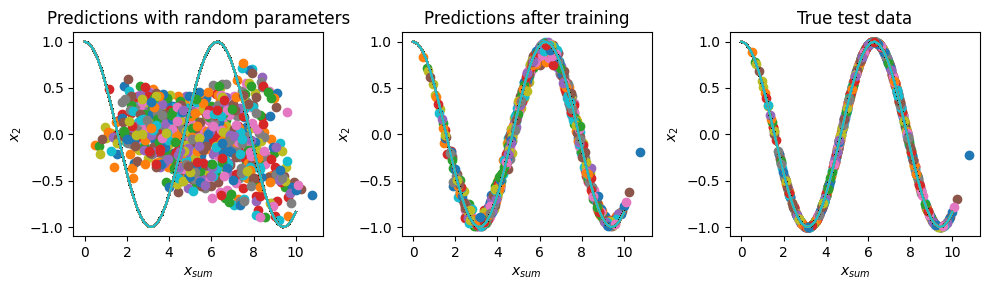

In [52]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, score_train, score_test
    )
)

print("Learned weights")
print("thetas = {}".format(thetas))
print("phis = {}".format(phis))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data, alphas, initial_predictions, fig, axes[0])
plot_data(test_data, alphas, pred_test, fig, axes[1])
plot_data(test_data, alphas, test_target, fig, axes[2])

axes[0].set_title("Predictions with random parameters")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


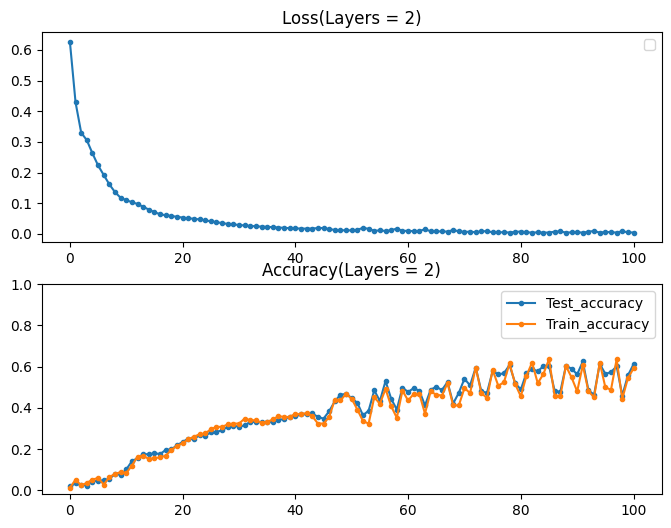

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test_accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train_accuracy')
axes[0].legend()
axes[1].legend()
axes[1].set_ylim(top = 1.0)
axes[0].set_title(f"Loss(Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()

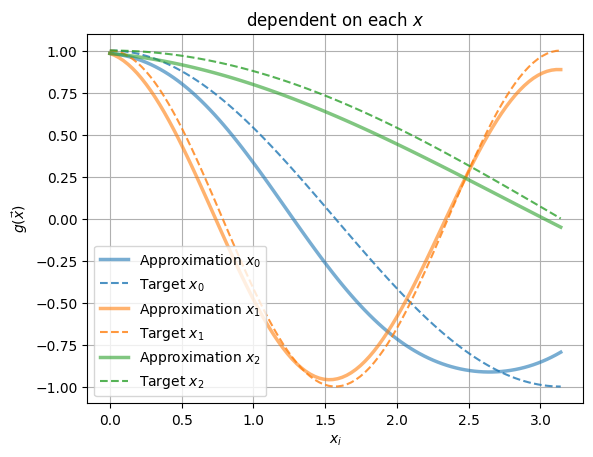

In [54]:
xlin = np.linspace(0,np.pi,100)
arr = np.zeros(100)

num_layers = 2
alphas = [1, 2, 1/2]
dim = len(alphas)

xlin_data1 = np.stack((xlin, arr, arr), axis=1)
xlin_data2 = np.stack((arr, xlin, arr), axis=1)
xlin_data3 = np.stack((arr, arr, xlin), axis=1)

xlin_data = np.stack((xlin_data1, xlin_data2, xlin_data3), axis=0)

for i in range(dim):
        ypred = model_running(thetas, phis, xlin_data[i], num_layers)
        ytrue = np.cos(alphas[i]*xlin)

        color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]

        plt.plot(xlin, 
                ypred,
                label=f"Approximation $x_{i}$",
                linewidth = 2.5,
                alpha = 0.6,
                ls = "-",
                color = color)

        plt.plot(
                xlin,
                ytrue,
                label=f"Target $x_{i}$",
                linewidth=1.5,
                alpha=0.8,
                ls="--",
                color=color)

plt.grid(True)
plt.title(f"dependent on each $x$")
plt.xlabel(f"$x_i$")
plt.ylabel(r"$g({\vec{x}})$")
plt.legend()
plt.show()